## Data

https://github.com/AlirezaShamsoshoara/Fire-Detection-UAV-Aerial-Image-Classification-Segmentation-UnmannedAerialVehicle

In [2]:
RANDOM_STATE = 42

In [3]:
!unzip images.zip -d iamges

unzip:  cannot find or open images.zip, images.zip.zip or images.zip.ZIP.


In [4]:
!unzip masks.zip -d masks

unzip:  cannot find or open masks.zip, masks.zip.zip or masks.zip.ZIP.


In [5]:
import numpy as np

In [6]:
#from google.colab.patches import cv2_imshow

In [7]:
IMAGE_RESIZE = (512, 512)

In [8]:
import cv2
import os

def load_images_from_folder(folder, is_mask, resize_shape=(512, 512)):
    images = []
    i = 0
    for filename in os.listdir(folder):
        if is_mask:
            img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(folder,filename))

        if img is not None:
            img = cv2.resize(img, resize_shape, interpolation = cv2.INTER_AREA)
            images.append(img)
        i+=1
        #if i == 100:
        #    break
        
    return np.array(images)

In [9]:
images = load_images_from_folder('./content/Images', is_mask=False)

In [10]:
masks = load_images_from_folder('./content/Masks', is_mask=True)

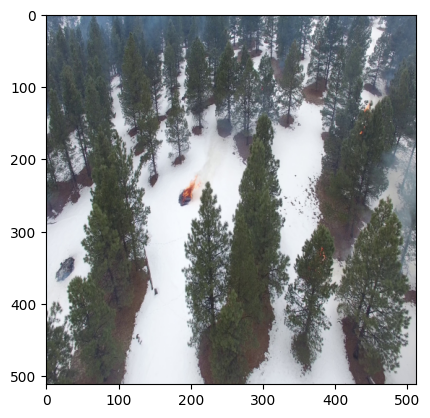

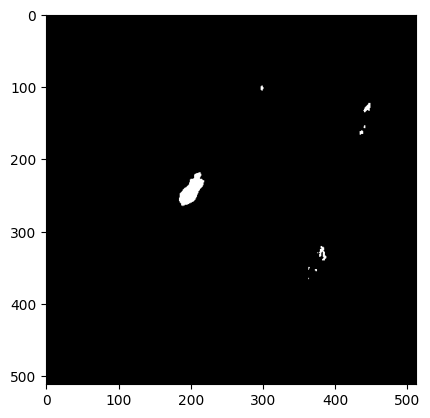

In [11]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(images[100], cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(masks[100], cmap='gray', vmin=0., vmax=1.)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(images, masks, test_size=0.15, shuffle=True, random_state=RANDOM_STATE)

In [13]:
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=RANDOM_STATE)

In [14]:
print(f'Train shapes: {X_train.shape}, {y_train.shape}')
print(f'Val shapes: {X_val.shape}, {y_val.shape}')
print(f'Test shapes: {X_test.shape}, {y_test.shape}')

Train shapes: (1531, 512, 512, 3), (1531, 512, 512)
Val shapes: (171, 512, 512, 3), (171, 512, 512)
Test shapes: (301, 512, 512, 3), (301, 512, 512)


## Model

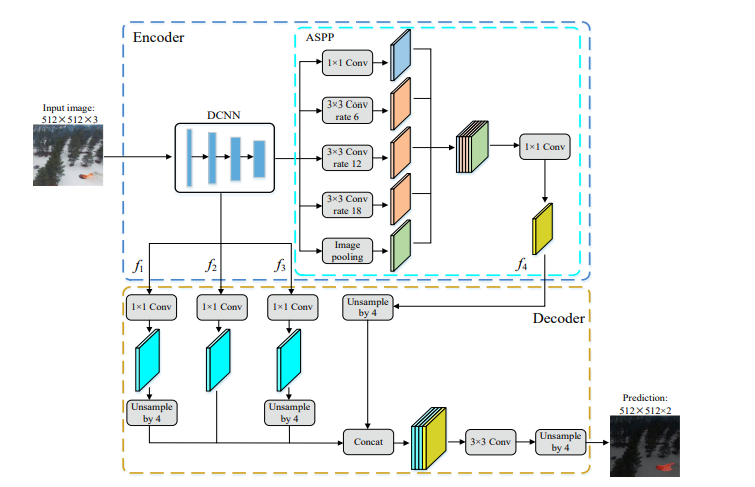

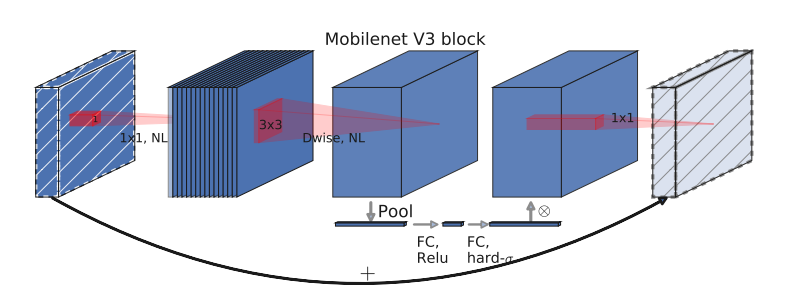

In [15]:
import torch
from torch import nn 
import torch.nn.functional as F

In [16]:
class MobileBottleNeck(nn.Module):

    def __init__(self, in_channels, expansion, out_channels, kernel_size, activation_layer, use_squeeze_excitation, stride=1, padding=1):
        super(MobileBottleNeck, self).__init__()

        self.use_skip_conn = stride == 1 and in_channels == out_channels
        self.use_squeeze_excitation = use_squeeze_excitation

        self.standard_conv = nn.Sequential(
            nn.Conv2d(in_channels, expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(expansion),
            activation_layer(),
        )


        # DEPTH-WISE CONV


        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(expansion, expansion, kernel_size=kernel_size, stride=stride, 
                                        groups=expansion, padding=padding, bias=False),
            nn.BatchNorm2d(expansion),
        )

        # SQUEEZE-AND-EXCITATION

        self.squeeze_excitation = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Conv2d(expansion, in_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, expansion, kernel_size=1),
            nn.Hardswish(),
        )


        # POINTWISE CONVOLUTION
        self.pointwise_conv = nn.Sequential( 
            nn.Conv2d(expansion, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            activation_layer(),
        )

    def forward(self, x):
        residual = x.clone()

        # STANDARD CONV
        out = self.standard_conv(x)

        # DEPTH-WISE CONV
        depth_wise_out = self.depthwise_conv(out)
        if self.use_squeeze_excitation:
            # SQUEEZE-AND-EXCITATION
            out = self.squeeze_excitation(depth_wise_out)

            out = out * depth_wise_out    
        
        else:
            out = depth_wise_out

            
        # POINTWISE CONVOLUTION
        out = self.pointwise_conv(out)

        if self.use_skip_conn:
            out = out + residual

        return out

In [17]:
class DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        in_channels = 3

        # INPUT LAYERS
        self.input_convolution = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.Hardswish(),
        )

        # BOTTLENECKS 
        self.bottleneck1 =  nn.Sequential(
            MobileBottleNeck(16, 16, 16, 3, nn.ReLU, False, stride=1),
        )

        self.bottleneck2 =  nn.Sequential(
            MobileBottleNeck(16, 64, 24, 3, nn.ReLU, False, stride=2, padding=1),
            MobileBottleNeck(24, 72, 24, 3, nn.ReLU, False, stride=1),
        )

        self.bottleneck3 =  nn.Sequential(
            MobileBottleNeck(24, 72, 40, 5, nn.ReLU, True, stride=2, padding=2),
            MobileBottleNeck(40, 120, 40, 5, nn.ReLU, True, stride=1, padding=2),
            MobileBottleNeck(40, 120, 40, 5, nn.ReLU, True, stride=1, padding=2),
        )    
        self.bottleneck4 =  nn.Sequential(        
            MobileBottleNeck(40, 240, 80, 3, nn.Hardswish, False, stride=2),
            MobileBottleNeck(80, 200, 80, 3, nn.Hardswish, False, stride=1),
            MobileBottleNeck(80, 184, 80, 3, nn.Hardswish, False, stride=1),
            MobileBottleNeck(80, 184, 80, 3, nn.Hardswish, False, stride=1),
            MobileBottleNeck(80, 480, 112, 3, nn.Hardswish, True, stride=1),
            MobileBottleNeck(112, 672, 160, 3, nn.Hardswish, True, stride=1),
            MobileBottleNeck(160, 672, 160, 5, nn.Hardswish, True, stride=1, padding=2),
            MobileBottleNeck(160, 960, 160, 5, nn.Hardswish, True, stride=1, padding=2),
            MobileBottleNeck(160, 960, 160, 5, nn.Hardswish, True, stride=1, padding=2),
        )

    def forward(self, x):
        out = self.input_convolution(x)
        f1 = self.bottleneck1(out)
        f2 = self.bottleneck2(f1)
        f3 = self.bottleneck3(f2)
        out = self.bottleneck4(f3)
        
        return f1, f2, f3, out

In [18]:
class ASPP(nn.Module):
    def __init__(self):
        super().__init__()

        in_channels = 160
        out_channels = 256

        # STANDARD CONVOLUTION LAYER

        self.standard_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        # ATROUS CONVOLUTION LAYERS

        self.atrous_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, bias=False, dilation=6, padding=6),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.atrous_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, bias=False, dilation=12, padding=12),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.atrous_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, bias=False, dilation=18, padding=18),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        # IMAGE POOLING
        self.image_pooling = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.final_conv = nn.Sequential(
            nn.Conv2d(out_channels*5, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x):

        out1 = self.standard_conv(x)
        out2 = self.atrous_conv_1(x)
        out3 = self.atrous_conv_2(x)
        out4 = self.atrous_conv_3(x)

        out5 = self.image_pooling(x)
        # replicate spatially the pooling result
        out5 = F.interpolate(out5, size=x.shape[-2:], mode='bilinear', align_corners=False)

        out = torch.cat([out1, out2, out3, out4, out5], dim=1)
        f4 = self.final_conv(out)

        return f4

In [19]:
t1 = torch.randn(72, 2, 1, 1)
t2 = torch.randn(72, 2, 65, 65)
t2*t1

tensor([[[[ 5.8574e-01,  9.1554e-01,  1.2623e+00,  ..., -1.7737e+00,
           -1.0082e+00,  8.8122e-01],
          [-1.6919e+00, -1.0426e+00,  5.2215e-01,  ..., -4.0016e-01,
            7.7995e-01,  3.7537e-01],
          [ 1.1711e+00, -3.7095e-01, -2.1279e-01,  ..., -6.1892e-01,
           -7.0931e-01,  1.6479e+00],
          ...,
          [-1.5076e-01, -3.6185e-01, -1.3510e+00,  ..., -1.3121e+00,
            1.5639e+00,  4.3883e-01],
          [ 1.4290e-01, -1.4182e+00, -1.6301e+00,  ..., -3.9883e-01,
           -8.6234e-01, -8.3174e-01],
          [-8.9044e-01, -2.9650e-01,  1.3032e+00,  ...,  2.1297e-01,
           -1.4142e+00, -5.1877e-01]],

         [[-1.6660e-01,  2.8364e-01, -1.0445e-01,  ..., -5.0658e-01,
           -3.4081e-01, -5.1443e-01],
          [ 9.8160e-02, -2.4812e-02, -1.5814e-01,  ...,  3.9866e-01,
           -6.8354e-01, -3.8816e-01],
          [ 3.3206e-01, -6.9562e-01, -1.6071e-01,  ...,  1.9313e-01,
            1.3358e-01, -9.1768e-01],
          ...,
     

In [20]:
tensor = torch.randn(2, 3, 512, 512)

In [21]:
import torch
from torch import nn 

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dcnn = DCNN()
        self.aspp = ASPP()

    def forward(self, x):
        f1, f2, f3, out = self.dcnn(x)
        f4 = self.aspp(out)
        return f1, f2, f3, f4 

In [22]:
enc = Encoder()
enc(tensor)

(tensor([[[[ 1.2055e+00, -5.4198e-02,  1.5441e+00,  ..., -2.1827e-01,
             2.4702e+00,  1.5953e-01],
           [-9.9333e-02,  5.1033e-01,  7.6262e-02,  ...,  1.5469e-01,
            -2.5446e-01,  9.6825e-01],
           [-3.6500e-01,  6.0493e-01, -2.3883e-01,  ...,  2.5476e-01,
            -8.7366e-03,  4.7974e-01],
           ...,
           [ 3.4940e-01,  7.7391e-01, -3.9458e-02,  ...,  7.8423e-01,
            -3.1841e-01,  2.6614e+00],
           [ 3.0765e-01, -2.2879e-01,  5.0360e-01,  ...,  4.7824e-01,
             5.6486e-01,  7.6292e-01],
           [ 1.0099e+00, -1.2764e-01, -3.3205e-01,  ...,  4.2556e-01,
             1.8165e+00,  5.4980e-01]],
 
          [[ 1.2718e-01, -3.1655e-02,  1.3089e-01,  ..., -2.8849e-01,
            -3.6907e-01, -2.9965e-02],
           [ 4.3665e-01,  1.2161e+00, -2.3024e-01,  ...,  7.8515e-02,
             9.6122e-01,  1.7496e+00],
           [ 1.7623e+00, -3.7671e-02,  1.5428e+00,  ..., -3.6320e-01,
             5.0306e-01, -1.0760e-01],


In [23]:
import torch
from torch import nn 

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        out_channels = 256
        f2_size = (128, 128)

        self.conv_f1 = nn.Sequential(
            nn.Conv2d(16, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv_f2 = nn.Sequential(
            nn.Conv2d(24, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv_f3 = nn.Sequential(
            nn.Conv2d(40, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.upsample_f1 = nn.Upsample(f2_size, mode='bilinear', align_corners=False)
        self.upsample_f3 = nn.Upsample(f2_size, mode='bilinear', align_corners=False)
        self.upsample_f4 = nn.Upsample(f2_size, mode='bilinear', align_corners=False)

        self.final_conv = nn.Sequential(
            nn.Conv2d(out_channels * 4, 1, kernel_size=3, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )

        self.final_upsample = nn.Upsample((512, 512), mode='bilinear', align_corners=False)

    def forward(self, f1, f2, f3, f4):
        out_f1 = self.conv_f1(f1)
        out_f2 = self.conv_f2(f2)
        out_f3 = self.conv_f3(f3)

        out_f1 = self.upsample_f1(out_f1)
        out_f3 = self.upsample_f3(out_f3)
        out_f4 = self.upsample_f4(f4)

        out = torch.cat([out_f1, out_f2, out_f3, out_f4], dim=1)

        out = self.final_conv(out)
        out = self.final_upsample(out)

        return out

In [24]:
import torch
from torch import nn 

class FireSegmentationModel(nn.Module):
    def __init__(self, device: str):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.to(device)
        
    def forward(self, x: torch.FloatTensor):
        #x = x.permute(0, 3, 1, 2)
        f1, f2, f3, f4 = self.encoder(x)
        out = self.decoder(f1, f2, f3, f4)
        #out = out.permute(0, 2, 3, 1)
        return out
        

In [46]:
model = FireSegmentationModel('cuda')

In [47]:
#res = model(torch.tensor(images[0:2], device='cuda', dtype=torch.float32).permute(0,3,1,2))

In [48]:
#res

In [49]:
from typing import Tuple
from torch.utils.data.dataloader import Dataset, DataLoader, Optional
from torchvision.transforms import  Compose, ToTensor, RandomResizedCrop, RandomAffine, ColorJitter, RandomHorizontalFlip, RandomPerspective

transform_image_and_mask = Compose([
    RandomResizedCrop(IMAGE_RESIZE, scale=(0.7, 1.)),
    ColorJitter(brightness=.2, hue=.2),
    RandomPerspective(distortion_scale=.3),
    RandomHorizontalFlip(),
    RandomAffine(degrees=(-45, 45), translate=(0.1, 0.1), scale=(0.8, 1.2))])
transform_image = ColorJitter(brightness=.2, hue=.2)

class FireDetectionDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, 
                 transform_image_and_mask: Optional[Compose] = None,
                 transform_image: Optional[ColorJitter] = None) -> None:
        super().__init__()
        assert x.shape[:-1] == y.shape
        self.x = x
        self.y = y
        self.len = x.shape[0]
        self.transform_image_and_mask = transform_image_and_mask
        self.transform_image = transform_image
        self.to_tensor = ToTensor()
    
    def __getitem__(self, index: int) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        x = self.x[index]
        y = self.y[index]

        x = self.to_tensor(x)
        y = self.to_tensor(y)

        if self.transform_image_and_mask is not None:
            y = y.expand_as(x)
            x_y = torch.cat([x.unsqueeze(0), y.unsqueeze(0)], dim=0)
            x_y = self.transform_image_and_mask(x_y)
            x, y = x_y[0], x_y[1]
            y = y[:1]
        if self.transform_image is not None:
            x = transform_image(x)
        #print('x', x)
        #print('y', y)

        return x, y
    
    def __len__(self) -> int:
        return self.len
    


In [50]:
TRAIN_BATCH_SIZE = 2
EVAL_BATCH_SIZE = 4

train_loader = DataLoader(FireDetectionDataset(X_train, y_train), #transform_image_and_mask, transform_image),
                          batch_size=TRAIN_BATCH_SIZE, shuffle=True)

val_loader = DataLoader(FireDetectionDataset(X_val, y_val),
                          batch_size=EVAL_BATCH_SIZE, shuffle=False)

test_loader = DataLoader(FireDetectionDataset(X_test, y_test),
                          batch_size=EVAL_BATCH_SIZE, shuffle=False)

In [51]:
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

optimizer = SGD(model.parameters(), lr=3e-3, nesterov=True, weight_decay=3e-6, momentum=.9)
lr_scheduler = StepLR(optimizer, gamma=6e-1, step_size=2)

In [52]:
import torch.nn as nn
import torch.nn.functional as F
import torch 

class FocalLoss(nn.Module):
    def __init__(self, gamma=.5):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, y_pred, y_true):
        pt = F.cross_entropy(
            y_pred, y_true, reduction='none')
        #pt = torch.exp(-ce_loss)
        focal_loss = - (1 - pt)**self.gamma * torch.log(pt)
        return focal_loss.mean()

In [53]:
import os
from time import time
from typing import Dict, Optional, Tuple
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

class Checkpoint():
    """Class to handle the checkpoints of a model."""
    def __init__(self, path: str, initial_error: float = float('inf')) -> None:
        """Initialize the checkpoint instance.
        
        Parameters
        ----------
        path : str
            The checkpoint path.
        initial_error : float, optional
            The initial error value, by default inf.
        """
        self.last_error = initial_error

        self.path = path
        os.makedirs(os.path.dirname(self.path), exist_ok=True)

    def save_best(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                  new_error: float) -> None:
        """Possibly save the best model weights and optimizer state 
        in the checkpoint file according to the new value of the metric.
        
        Parameters defined in `kwargs` are also saved in the checkpoints
        as an ndarray. 
        
        Parameters
        ----------
        model : Module
            The model which weights are saved.
        optimizer : Optimizer
            The optimizer which state is saved
        new_error : float
            The new error value which is compared to the best so far.
            The checkpoints are updated solely if the new error is less.
        """
        if new_error < self.last_error:
            checkpoint = {}
            checkpoint['model_state_dict'] = model.state_dict()
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
            checkpoint['best_error'] = new_error

            torch.save(checkpoint, self.path)

        self.last_error = new_error

    def load_best_weights(self, model: nn.Module) -> None:
        """Load the best weights on a model.

        Parameters
        ----------
        model : Module
            The model for which the best weights are loaded.
        """
        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])

def train(
    model: FireSegmentationModel, optimizer: torch.optim.Optimizer,
    lr_scheduler: Optional[object],
    train_dataloader: DataLoader, val_dataloader: DataLoader,
    epochs: int, device: str, checkpoint: Optional[Checkpoint] = None,
    reload_best_weights: bool = True) -> Dict[str, np.ndarray]:
    # Initialize loss functions.
    criterion = FocalLoss()

    # Initialize histories.
    metrics = ['train_loss', 'train_mpa', 'train_miou', 'val_loss', 'val_mpa',
               'val_miou']
    history = { m: [] for m in metrics }

    # Set model in training mode.
    model.train()

    # Iterate across the epochs.
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Remove unused tensors from gpu memory.
        torch.cuda.empty_cache()

        # Initialize running loss and errors.
        running_train_loss = 0.
        running_train_mpa = 0.
        running_train_miou = 0.

        start_time = time()

        for batch_idx, data in enumerate(train_dataloader, 0):
            # Increment the number of batch steps.
            batch_steps = batch_idx + 1

            # Get the data.
            x, y = data
            x = x.to(device=device)
            y = y.to(device=device)

            # Compute model predictions.
            y_pred = model(x)

            # Compute the loss on the scaled results and ground truth.
            loss = criterion(y_pred, y)
            running_train_loss += loss.item()

            # Zero the gradients.
            optimizer.zero_grad()

            # Compute errors and update running errors.
            # TODO: add mpa miou
            #mpa = 
            #miou =

            #running_train_mpa += mae.item()
            #running_train_riou += rmse.item()

            # Use the loss function for backpropagation.
            loss.backward()

            # Update the weights.
            optimizer.step()

            epoch_time = time() - start_time
            batch_time = epoch_time / batch_steps

            print(
                f'[{batch_steps}/{len(train_dataloader)}] -',
                f'{epoch_time:.0f}s {batch_time * 1e3:.0f}ms/step -',

                f'train {{ loss: {running_train_loss / batch_steps:.3g} -',
                #f'MPA: {running_train_mae / batch_steps:.3g} -',
                #f'MiOU: {running_train_mape * 100. / batch_steps:.3g}% }} -',

                f'lr: {optimizer.param_groups[0]["lr"]:.3g} -',
                '             ' if batch_steps < len(train_dataloader) else '',
                end='\r')

        # Set the model in evaluation mode.
        model.eval()

        '''train_loss = running_train_loss / len(train_dataloader)
        train_mae = running_train_mae / len(train_dataloader)
        train_rmse = running_train_rmse / len(train_dataloader)
        train_smape = running_train_mape / len(train_dataloader)

        history['train_loss'].append(train_loss)
        history['train_mae'].append(train_mae)
        history['train_rmse'].append(train_rmse)
        history['train_smape'].append(train_smape)

        val_results = validate(model, val_dataloader, mae_function, 
                               rmse_function, mape_function, scaler, device)
        val_loss, val_mae, val_rmse, val_smape = val_results

        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_rmse'].append(val_rmse)
        history['val_smape'].append(val_smape)'''

        if checkpoint is not None:
            pass
            #err_sum = val_mae + val_rmse + val_smape
            #checkpoint.save_best(model, optimizer, err_sum)

        '''print(
            f'[{len(train_dataloader)}/{len(train_dataloader)}] -',
            f'{epoch_time:.0f}s -',

            f'train: {{ loss: {train_loss:.3g} -',
            f'MAE: {train_mae:.3g} -',
            f'RMSE: {train_rmse:.3g} -',
            f'sMAPE: {train_smape * 100.:.3g}% }} -',

            f'val: {{ loss: {val_loss:.3g} -',
            f'MAE: {val_mae:.3g} -',
            f'RMSE: {val_rmse:.3g} -',
            f'sMAPE: {val_smape * 100.:.3g}% }} -',

            f'lr: {optimizer.param_groups[0]["lr"]:.3g} -',
            f'weight decay: {optimizer.param_groups[0]["weight_decay"]}')'''

        lr_scheduler.step()

        # Set model in training mode.
        model.train()

    if checkpoint is not None and reload_best_weights:
        checkpoint.load_best_weights(model)

    model.eval()

    # Remove unused tensors from gpu memory.
    torch.cuda.empty_cache()

    # Turn histories in ndarrays.
    for k, v in history.items():
        history[k] = np.array(v)

    return history

def validate(
    model: nn.Module, val_dataloader: DataLoader, mae_function: nn.Module,
    rmse_function: nn.Module, mape_function: nn.Module, scaler: object, device: str, 
    n_timestamps_to_predict: Optional[int] = None
    ) -> Tuple[float, float, float, float]:
    torch.cuda.empty_cache()

    running_val_loss = 0.
    running_val_mae = 0.
    running_val_rmse = 0.
    running_val_smape = 0.

    with torch.no_grad():
        for _, data in enumerate(val_dataloader, 0):
            # Get the data.
            x, y = data
            x = scaler.scale(x)
            x = x.type(torch.float32).to(device=device)
            y = y.type(torch.float32).to(device=device)

            # Compute output.
            y_pred = model(x)
            print(y_pred)

            if n_timestamps_to_predict is not None:
                y_pred = y_pred[:, : n_timestamps_to_predict]
                y = y[:, : n_timestamps_to_predict]

            loss = mae_function(y_pred, scaler.scale(y))
            running_val_loss += loss.item()

            y_pred = scaler.un_scale(y_pred)

            # Loss
            mae = mae_function(y_pred, y)
            rmse = rmse_function(y_pred, y)
            mape = mape_function(y_pred, y)
            running_val_mae += mae.item()
            running_val_rmse += rmse.item()
            running_val_smape += mape.item()

    torch.cuda.empty_cache()

    val_loss = running_val_loss / len(val_dataloader)
    val_mae = running_val_mae / len(val_dataloader)
    val_rmse = running_val_rmse / len(val_dataloader)
    val_smape = running_val_smape / len(val_dataloader)

    return val_loss, val_mae, val_rmse, val_smape


In [54]:
EPOCHS = 30

train(model, optimizer, lr_scheduler, train_loader, val_loader, 30, 'cuda', None, False)

Epoch 1/30


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 6.00 GiB total capacity; 5.22 GiB already allocated; 0 bytes free; 5.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF